In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_excel('/content/drive/MyDrive/country_lyrics.xlsx')

In [5]:
data.head()

,Song,Artist,Featuring,Entered Top 30 In:,Lyrics,Writers,Producer,Rough Order,Unnamed: 8,RULES!!!! Top 30 Country Airplay From March 2014-March 2017
0,Wake Up Lovin You,Craig Morgan,NaN,2013,My friends call me up 'cause they know I'm dow...,"Josh Osborne, Matthew Ramsey, Trevor Rosen","Craig Morgan, Phil O'Donnell",1,NaN,NaN
1,Young Love,Kip Moore,NaN,2013,"Your daddy thought I was wrong for you, Thinki...","Kip Moore, Dan Couch, Westin Davis",Brett James,2,NaN,NaN
2,Beat of the Music,Brett Eldredge,NaN,2013,Well I just met you a couple hours ago My last...,"Brett Eldredge, Ross Copperman, Heather Morgan","Brett Eldredge, Ross Copperman",3,NaN,NaN
3,The Heart of Dixie,Danielle Bradbery,NaN,2013,She had a dead-end job at the National Bank An...,"Brett James, Caitlyn Smith, Troy Verges",Brett James,4,NaN,NaN
4,Everything I Shouldn't Be Thinking About,Thompson Square,NaN,2013,My motorcycle needs an oil change Fence needs ...,"Keifer Thompson, Shawna Thompson, David Lee Mu...","RIch Redmond, Kurt Allison, Tully Kennedy, Dav...",5,NaN,NaN


In [6]:
data.columns

Index(['Song', 'Artist', 'Featuring', 'Entered Top 30 In:', 'Lyrics',
       'Writers', 'Producer', 'Rough Order', 'Unnamed: 8',
       'RULES!!!! Top 30 Country Airplay From March 2014-March 2017'],
      dtype='object')

In [7]:
dataset = data.iloc[:,:8]

In [8]:
dataset[['Artist','Song']].groupby(['Artist']).count().sort_values(by='Song',ascending=False).reset_index().head(10)

,Artist,Song
0,Luke Bryan,16
1,Blake Shelton,15
2,Thomas Rhett,14
3,Jason Aldean,14
4,Florida Georgia Line,13
5,Keith Urban,12
6,Tim McGraw,11
7,Kenny Chesney,11
8,Eric Church,11
9,Cole Swindell,10


In [9]:
dataset[['Producer','Song']].groupby(['Producer']).count().sort_values(by='Song',ascending=False).reset_index().head(10)

,Producer,Song
0,Dann Huff,31
1,Jay Joyce,27
2,Joey Moi,26
3,Scott Hendricks,23
4,Michael Knox,14
5,Ross Copperman,11
6,"Jeff Stevens, Jody Stevens",11
7,Michael Carter,10
8,Shane McAnally,9
9,busbee,8


In [10]:
print(len(dataset.Producer.unique()))
print(len(dataset.Artist.unique()))

180
121


In [11]:
dataset['temp'] = dataset.Producer.str.split(',')
dataset_prod = (dataset.set_index(['Song', 'Artist', 'Featuring', 'Entered Top 30 In:', 'Lyrics','Writers', 'Producer', 'Rough Order'])['temp'].apply(pd.Series).stack().reset_index().drop('level_8', axis=1).rename(columns={0:'all_producers'}))

In [12]:
dataset_prod[['all_producers','Song']].groupby(['all_producers']).count().sort_values(by='Song',ascending=False).reset_index().head(10)

,all_producers,Song
0,Dann Huff,51
1,Joey Moi,28
2,Jay Joyce,27
3,Scott Hendricks,24
4,Ross Copperman,22
5,Jeff Stevens,15
6,Michael Knox,14
7,Zach Crowell,13
8,Byron Gallimore,12
9,busbee,12


In [13]:
data_lyrics = data.iloc[:,4:5]
data_lyrics.head()

,Lyrics
0,My friends call me up 'cause they know I'm dow...
1,"Your daddy thought I was wrong for you, Thinki..."
2,Well I just met you a couple hours ago My last...
3,She had a dead-end job at the National Bank An...
4,My motorcycle needs an oil change Fence needs ...


In [14]:
import re
import nltk
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
my_stopwords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'

# cleaning function
def clean_lyrics(lyrics, bigrams=False, stemm=False):
    lyrics = lyrics.lower() # lower case
    lyrics = re.sub('['+my_punctuation + ']+', ' ', lyrics) # strip punctuation
    lyrics = re.sub('\s+', ' ', lyrics) #remove double spacing
    lyrics = re.sub('([0-9]+)', '', lyrics) # remove numbers
    lyrics_token_list = [word for word in lyrics.split(' ') if word not in my_stopwords] # remove stopwords

    if stemm:
      lyrics_token_list = [word_rooter(word) if '#' not in word else word for word in lyrics_token_list] # apply word rooter
    
    if bigrams:
        lyrics_token_list = lyrics_token_list+[lyrics_token_list[i]+'_'+lyrics_token_list[i+1]
                                            for i in range(len(lyrics_token_list)-1)]
    lyrics = ' '.join(lyrics_token_list)
    return lyrics

In [16]:
data_lyrics['Lyrics'] = data_lyrics.Lyrics.apply(clean_lyrics)

In [17]:
data_lyrics.head()

,Lyrics
0,friends call cause know take paint town help g...
1,daddy thought wrong thinking back mom two wron...
2,well met couple hours ago last night town hey ...
3,dead end job national bank deadbeat husband al...
4,motorcycle needs oil change fence needs mendin...


In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

## LDA
# the vectorizer object will be used to transform text to vector form
vectorizer = CountVectorizer(max_df=0.9, min_df=2, max_features=1000)
# apply transformation
tf = vectorizer.fit_transform(data_lyrics['Lyrics']).toarray()
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()


## NMF
# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data_lyrics['Lyrics'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [19]:
tf.shape

(484, 1000)

In [20]:
tfidf.shape

(484, 1000)

## Added NMF alsong with LDA
NMF gives better topics than the topics defined by LDA

In [25]:
from sklearn.decomposition import LatentDirichletAllocation, NMF

number_of_topics = 5
model_lda = LatentDirichletAllocation(n_components=number_of_topics, random_state=10, batch_size=32)
model_nmf = NMF(n_components=number_of_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')

In [26]:
print(model_lda.fit(tf))
print(model_nmf.fit(tfidf))

LatentDirichletAllocation(batch_size=32, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=10, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
NMF(alpha=0.1, beta_loss='frobenius', init='nndsvd', l1_ratio=0.5, max_iter=200,
    n_components=5, random_state=1, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)


In [27]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [28]:
no_top_words = 10
display_topics(model_lda, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,one,239.1,love,331.0,oh,545.2,like,414.7,wanna,477.0
1,like,215.0,like,225.6,like,226.3,got,312.4,girl,470.2
2,know,159.0,somebody,199.2,little,181.0,get,310.7,yeah,376.9
3,still,155.4,got,174.4,ooh,158.3,know,307.9,baby,333.0
4,hey,144.4,know,166.3,love,155.7,baby,252.7,take,286.8
5,gonna,144.3,gonna,149.3,every,153.4,girl,218.9,back,266.4
6,yeah,132.7,yeah,146.6,time,133.4,yeah,211.3,tonight,249.0
7,got,126.0,good,144.5,yeah,129.5,go,200.4,like,219.5
8,man,125.8,make,131.4,baby,103.5,little,196.7,got,214.9
9,always,116.4,world,124.5,way,89.6,way,193.9,little,184.7


In [29]:
no_top_words = 10
display_topics(model_nmf, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,left,0.6,needs,1.8,looks,1.9,wasted,1.7,somethin,1.6
1,friend,0.5,wonder,0.2,nights,0.5,lovin,0.6,glass,0.3
2,gives,0.5,workin,0.1,hallelujah,0.2,girl,0.6,key,0.2
3,anywhere,0.5,college,0.1,drown,0.2,loving,0.2,dancing,0.1
4,year,0.5,made,0.1,bars,0.2,boots,0.2,kisses,0.1
5,kisses,0.5,wild,0.1,breathe,0.1,laid,0.1,tequila,0.1
6,like,0.5,thinking,0.1,girl,0.1,clear,0.1,friends,0.1
7,tin,0.3,quite,0.1,leave,0.1,top,0.1,lie,0.1
8,red,0.3,gives,0.1,car,0.1,devil,0.1,life,0.0
9,girls,0.3,neon,0.1,hangover,0.1,dust,0.1,beat,0.0


## Clustering the lyrics 
Do a K-means and hierarchical clustering on the lyrics to find similar songs.
Do I need clustering? check

## Adding new lyrics 
Adding data for other genres to create a classification model by identifying country songs from the lyrics. Getting data from data.world https://data.world/typhon/billboard-hot-100-songs-2000-2018-w-spotify-data-lyrics
The data has lyrics and genres for mostly pop and rock songs. This should make the total data imbalanced and difficult for classification.


In [47]:
## check the encoding of the file
import chardet
with open('/content/drive/MyDrive/lyrics-data.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.99, 'encoding': 'utf-8', 'language': ''}

In [48]:
new_lyrics = pd.read_csv('/content/drive/MyDrive/lyrics-data.csv')

In [49]:
new_lyrics = new_lyrics.iloc[:,3:4]
new_lyrics['Lyric'] = new_lyrics.Lyric.apply(clean_lyrics)

In [50]:
# create a new column with 
data_lyrics['label'] = 1
new_lyrics['label'] = 0

In [51]:
data_lyrics.columns
data_lyrics = data_lyrics.append(new_lyrics.rename(columns={'Lyric':'Lyrics'}), ignore_index=True)

Index(['Lyrics', 'label'], dtype='object')

## Classifying the lyrics
Trying to classify songs into country and non country based on lyrics alone. 

### Exploring data

In [1]:
def get_num_words_per_sample(sample_texts):
    """Returns the median number of words per sample given corpus.

    # Arguments
        sample_texts: list, sample texts.

    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)

def song_length_distribution(data_lyrics):
  lyrics_length = list(data_lyrics.Lyrics.str.len())
  plt.hist(lyrics_length, 50)
  plt.xlabel('Length of a song')
  plt.ylabel('Number of songs')
  plt.title('Song length distribution')
  plt.show()

Country songs seem to have more words than songs from other genres

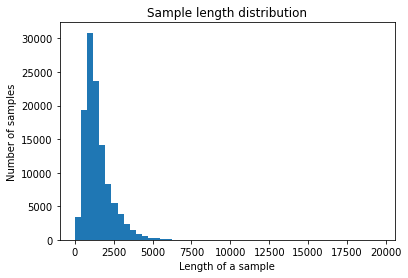

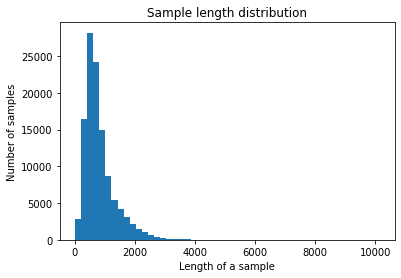

In [70]:
song_length_distribution(data_lyrics[data_lyrics.label == 1])
song_length_distribution(data_lyrics[data_lyrics.label == 0])